# Conheça melhor seus clientes utilizando RFM

## Aprenda como segmentar seus clientes com apenas três indicadores: recência, frequência e valor monetário.

Nesse artigo vou mostrar como criar um modelo RFM para chamar de seu, e ensinar como implementar o modelo com poucas linhas de código em Python. 

## Por que você faria uma análise RFM?

A segmentação RFM fará você entender melhor a sua base de clientes, por ser uma análise mais simples é uma ótima forma de começar com a análise de dados, e caso exista interesse da sua parte, pode ser aprofundada com técnicas e modelos mais avançados. 

Com o RFM você estará apto a responder perguntas de negócio como:

* Quem são os melhores clientes?
* Quais clientes estão deixando de comprar?
* Quais são os clientes mais leais?
* Quais clientes têm mais chances de comprar mais? 
* Quem são os clientes que não compram mais?
* Quem são os clientes que não posso perder de jeito nenhum?
* Quais clientes são mais suscetíveis a aceitar uma promoção?

## Prazer, RFM
RFM é um método estatístico simples utilizado para categorizar clientes baseados em seus hábitos de compra. Os hábitos são identificados através de três informações: recência (R), que para esse artigo vamos utilizar o número de dias desde a última compra do cliente, a frequência (F) em número vezes que o cliente fez uma compra e o valor monetário (M), que significa o valor entregue pelo cliente, para essa análise será a quantia total gasta pelo cliente durante o período analisado. Após estarmos com esses indicadores, vamos poder segmentar os clientes em grupos, que são:

* Campeões: Compraram recentemente, além de comprar com frequência e gastam muito.
* Clientes leais: Compradores recorrentes.
* Lealdade potencial: São clientes novos que compram com frequência.
* Novos Clientes: Compraram recentemente, mas não com frequência.
* Promissores: Compradores recentes, mas que não gastaram muito
* Em risco: Clientes que possuem uma frequência e valor monetário acima da média mas faz algum tempo que não compram, precisam ser trazidos de volta.
* Não posso perdê-los: São clientes que compravam com frequência e gastavam bastante, mas por algum motivo, não compram há algum tempo.
* Precisam de atenção: Estão na média da recência, frequência e valor monetário, talvez não comprem já a algum tempo.
* Prestes a hibernar: Abaixo da média de recência e frequência. Se nada for feito, muito provavelmente serão perdidos.
* Hibernando: Sua última compra já faz um tempo e foram poucas as vezes em que comprou, provavelmente será perdido em breve.
* Perdido: Já não compram mais há muito tempo, além de não terem consumido muito ou frequentado outras vezes. 






In [1]:
#importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/customer-personality-analysis/marketing_campaign.csv


In [2]:
df = pd.read_csv('../input/customer-personality-analysis/marketing_campaign.csv', sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## Conhecendo os dados e preparando o modelo

Vamos utilizar uma base de dados encontrada no kaggle para Análise de Personalidade do Cliente, nesse link você encontrará a descrição de cada feature, e caso seja do seu interesse se aprofundar mais no tema de segmentação de clientes, recomendo que dê uma olhada nos notebooks publicados por outros usuários, lá existem outras abordagens mais avançadas utilizando o mesmo dataset. 

Após uma primeira investigação, as colunas que vamos utilizar para construir nosso modelo são:

* ID: Código de identificação do cliente
* Recency: Número de dia desde a última compra daquele cliente
* NumWebPurchases: Número de compras feitas através do site da empresa
* NumCatalogPurchases: Número de compras feitas usando o catálogo
* NumStorePurchases: Número de compras feitas diretamente nas lojas
* MntWines: Quantia gasta com vinho nos últimos dois anos
* MntFruits: Quantia gasta com frutas nos últimos dois anos
* MntMeatProducts: Quantia gasta com carnes nos últimos dois anos
* MntFishProducts: Quantia gasta com peixes nos últimos dois anos
* MntSweetProducts: Quantia gasta com doces nos últimos dois anos
* MntGoldProds: Quantia gasta com produtos ouro nos últimos dois anos

Até aqui, só temos a recência (R), vamos então, somar o número de compras feitas pelos usuários nas diferentes opções que a empresa oferece, para assim, encontrarmos a frequência (F) de compra de cada usuário. 


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [4]:
df=df[['ID','Recency','MntWines','MntFruits','MntMeatProducts',
       'MntSweetProducts','MntFishProducts','MntGoldProds',
       'NumWebPurchases','NumCatalogPurchases','NumStorePurchases']]
df.head()

,ID,Recency,MntWines,MntFruits,MntMeatProducts,MntSweetProducts,MntFishProducts,MntGoldProds,NumWebPurchases,NumCatalogPurchases,NumStorePurchases
0,5524,58,635,88,546,88,172,88,8,10,4
1,2174,38,11,1,6,1,2,6,1,1,2
2,4141,26,426,49,127,21,111,42,8,2,10
3,6182,26,11,4,20,3,10,5,2,0,4
4,5324,94,173,43,118,27,46,15,5,3,6


Até aqui, só temos a recência (R), vamos então, somar o número de compras feitas pelos usuários nas diferentes opções que a empresa oferece, para assim, encontrarmos a frequência (F) de compra de cada usuário. 

In [5]:
#somando o número de compras em diferentes situações para encontrar a Frequência
df['Frequency'] = (df['NumWebPurchases'] + df['NumCatalogPurchases'] + 
                           df['NumStorePurchases'])

Para o valor monetário (M), vamos somar o valor gasto nas diferentes categorias de produtos.

In [6]:
#somando todos os gastos em uma só coluna para encontrar o valor monetário
df['MonetaryValue'] = (df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] 
                       + df['MntFishProducts'] + df['MntSweetProducts'] 
                       + df['MntGoldProds'])

In [7]:
#Vamos criar um novo dataframe apenas com as colunas que vamos utilizar no modelo.
RFM = df[['ID', 'Recency', 'Frequency', 'MonetaryValue']]
RFM

,ID,Recency,Frequency,MonetaryValue
0,5524,58,22,1617
1,2174,38,4,27
2,4141,26,20,776
3,6182,26,6,53
4,5324,94,14,422
...,...,...,...,...
2235,10870,46,16,1341
2236,4001,56,15,444
2237,7270,91,18,1241
2238,8235,8,21,843


Com a Recência, Frequência e Valor Monetário prontos, vamos fazer uma pequena inspeção e observar como nossos dados estão distribuídos.

In [8]:
fig = px.histogram(RFM, x='Recency')
fig.show()

Podemos notar que a recência está bem distribuída entre os usuários, existe quase a mesma quantidade de usuários para cada amostragem.

In [9]:
fig = px.histogram(RFM, x='Frequency')
fig.show()

Já a frequência, apesar de ter uma grande quantidade de clientes que não passaram de 10 compras, existe outra leva de clientes que passou e muito de 10 compras, sendo distribuídos entre 10 até 30.

In [10]:
fig = px.histogram(RFM, x='MonetaryValue')
fig.show()

Aqui em valor monetário, podemos observar que ¼ dos clientes não consumiram mais do que $100. 

## Atribuindo pontuações por quintil

As pontuações podem ser atribuídas de diversas formas, você pode usar a sua experiência de negócio para definir a quantidade de grupos que se encaixam melhor na sua base de clientes. Para essa análise, nós vamos dividir em quintis, uma das formas mais utilizadas por empresas ao fazer uso do RFM. 
O conceito é simples, para os valores de Frequência e Valor Monetário basta ordenar os dados do menor para o maior e dividir ele em cinco partes iguais. Cada uma dessas partes receberá uma nota de 1 a 5, sendo 5 a maior. Para a letra R é o contrário, vamos ordenar do maior para o menor, uma vez que, quanto menos tempo o cliente está sem comprar, melhor esse cliente é para empresa.

In [11]:
#Criando os rotulos
r_labels = range(5, 0, -1)
f_labels = range(1,6)
m_labels = range(1,6)

#Separando os dados 
r_quartiles = pd.qcut(RFM['Recency'], 5, labels=r_labels)
f_quartiles = pd.qcut(RFM['Frequency'], q=5, labels=f_labels)
m_quartiles = pd.qcut(RFM['MonetaryValue'], q=5, labels=m_labels)

#Atribuindo os novos rotulos
RFM = RFM.assign(R = r_quartiles, F=f_quartiles.values, M=m_quartiles.values)
RFM

,ID,Recency,Frequency,MonetaryValue,R,F,M
0,5524,58,22,1617,3,5,5
1,2174,38,4,27,4,1,1
2,4141,26,20,776,4,4,4
3,6182,26,6,53,4,2,1
4,5324,94,14,422,1,3,3
...,...,...,...,...,...,...,...
2235,10870,46,16,1341,3,4,5
2236,4001,56,15,444,3,3,3
2237,7270,91,18,1241,1,4,5
2238,8235,8,21,843,5,5,4


vamos tirar uma média entre a Frequência e Valor Monetário, para fazer isso basta somar ambas as notas e dividir por 2. O próximo passo agora é usar a matriz como referência para segmentar cada cliente. 

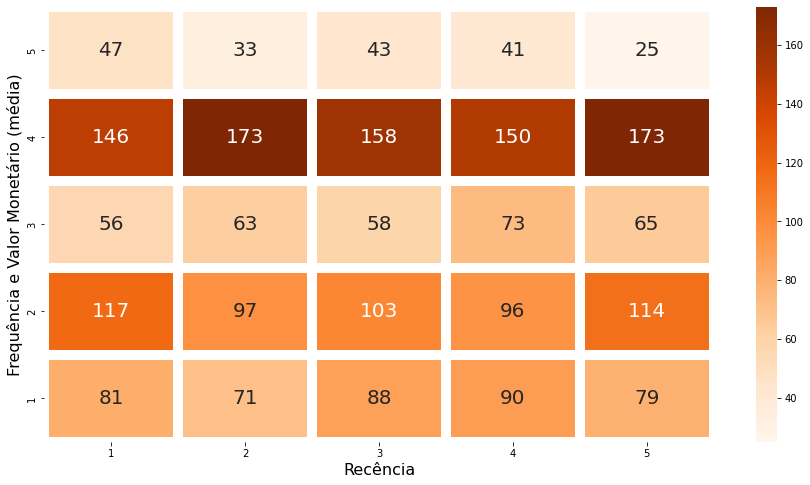

In [12]:
#Média de F+M
RFM['FM_mean'] = round( ( (RFM[ ['F','M'] ].sum(axis=1) ) / 2 ), 0 )

#Pivotando a tabela
RFMpivot = RFM.pivot_table(values='ID', index='FM_mean', columns='R', aggfunc='count')
RFMpivot = RFMpivot.loc[[5,4,3,2,1],[1,2,3,4,5]]

#Visualizando em um mapa de calor
plt.figure(figsize=(15,8))
plot = sns.heatmap(RFMpivot, annot=True, fmt='d', linewidths=10, 
            cmap='Oranges', annot_kws={"fontsize":20})
plot.set_xlabel('Recência', fontsize=16)
plot.set_ylabel('Frequência e Valor Monetário (média)', fontsize=16)
plt.show()

In [13]:
#Vamos descobrir agora a quem se pertence a cada grupo

RFM['R'] = RFM['R'].astype('int64')
RFM['FM_mean'] = RFM['FM_mean'].astype('int64')

#Irei atribuir os mesmos rótulos da imagem
def classificar(df):
    if (df['FM_mean'] == 5) and (df['R'] == 1):
      return 'Não posso perde-los'
    elif (df['FM_mean'] == 5) and (df['R'] == 2):
      return 'Em risco'
    elif (df['FM_mean'] == 4) and (df['R'] == 1):
      return 'Em risco'
    elif (df['FM_mean'] == 4) and (df['R'] == 2):
      return 'Em risco'
    elif (df['FM_mean'] == 3) and (df['R'] == 1):
      return 'Em risco'
    elif (df['FM_mean'] == 3) and (df['R'] == 2):
      return 'Em risco'
    elif (df['FM_mean'] == 5) and (df['R'] == 3):
      return 'Clientes leais'
    elif (df['FM_mean'] == 5) and (df['R'] == 4):
      return 'Clientes leais'
    elif (df['FM_mean'] == 4) and (df['R'] == 3):
      return 'Clientes leais'
    elif (df['FM_mean'] == 4) and (df['R'] == 4):
      return 'Clientes leais'
    elif (df['FM_mean'] == 4) and (df['R'] == 5):
      return 'Clientes leais'
    elif (df['FM_mean'] == 5) and (df['R'] == 5):
      return 'Campeões'
    elif (df['FM_mean'] == 3) and (df['R'] == 3):
      return 'Precisam de atenção'
    elif (df['FM_mean'] == 3) and (df['R'] >= 4):
      return 'Lealdade potêncial'
    elif (df['FM_mean'] == 2) and (df['R'] >= 4):
      return 'Lealdade potêncial'
    elif (df['FM_mean'] == 1) and (df['R'] <= 2):
      return 'Perdidos'
    elif (df['FM_mean'] == 2) and (df['R'] == 1):
      return 'Perdidos'
    elif (df['FM_mean'] == 2) and (df['R'] == 2):
      return 'Hibernando'
    elif (df['FM_mean'] <= 2) and (df['R'] == 3):
      return 'Prestes a hibernar'
    elif (df['FM_mean'] == 1) and (df['R'] == 4):
      return 'Promissor'
    else:
      return 'Recentes'

RFM['Classe'] = RFM.apply(classificar,axis=1)
RFM.value_counts('Classe')

Classe
Clientes leais         565
Em risco               471
Lealdade potêncial     348
Perdidos               269
Prestes a hibernar     191
Hibernando              97
Promissor               90
Recentes                79
Precisam de atenção     58
Não posso perde-los     47
Campeões                25
dtype: int64

Text(0.5, 0, 'Classes')

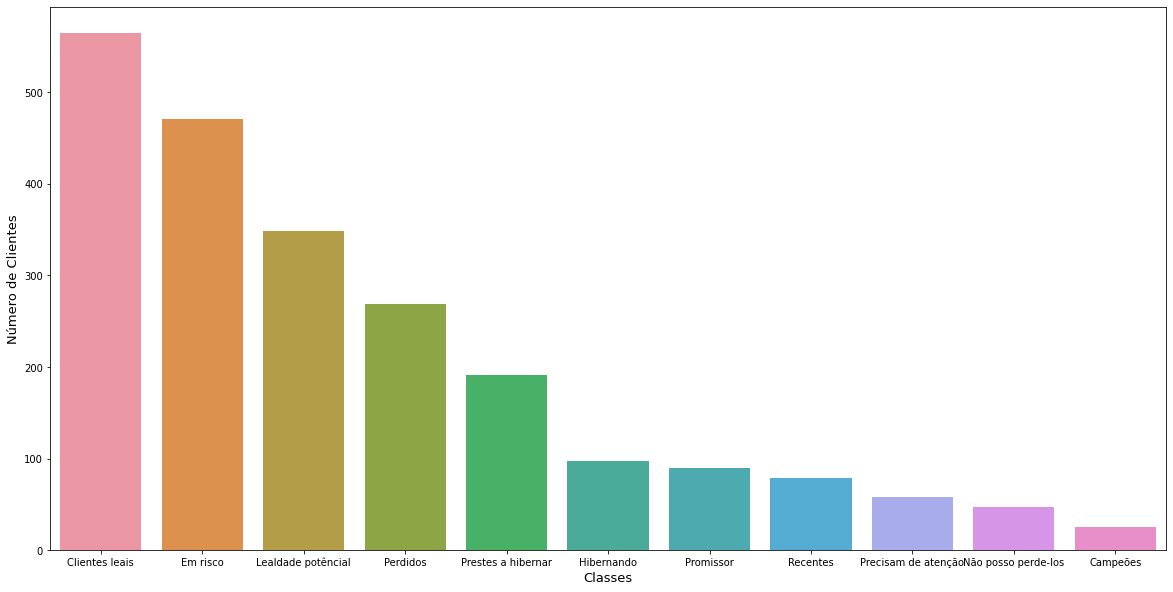

In [14]:
#Vamos plotar um gráfico de barras e ver quantos clientes residem em cada categoria
ord_rfm = RFM.groupby('Classe').agg('count').sort_values(by='ID',
                                                         ascending=False).index
plt.figure(figsize=(20,10))
ax = sns.countplot(x=RFM["Classe"], data=RFM, label=ord_rfm, order=ord_rfm)
plt.ylabel("Número de Clientes", fontsize=13)
plt.xlabel("Classes", fontsize=13)

A imagem mostra que o segundo maior grupo são de clientes em risco, o que pode se tornar uma oportunidade de conhecer melhor esse grupo para assim atraí-los a comprar novamente. 

## E agora?

Como podemos ver, o modelo RFM pode trazer insights valiosos utilizando apenas três indicadores. Agora, a nossa equipe pode focar esforços para conhecer melhor cada grupo e suas dores, valorizar os melhores clientes, atrair aqueles que estão deixando de comprar, e tentar recuperar aqueles que deixaram. 

